In [ ]:
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets

     |████████████████████████████████| 89 kB 1.5 MB/s 
     |████████████████████████████████| 4.7 MB 6.9 MB/s 


In [ ]:
import os
import pprint
import tempfile

from typing import Dict, Text

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

%matplotlib inline
import matplotlib.pyplot as plt

### Loading the movielens dataset

In [ ]:
ratings = tfds.load('movielens/100k-ratings', split="train")
movies = tfds.load('movielens/100k-movies', split="train")

# Select the basic features.
ratings = ratings.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"],
    "user_rating": x["user_rating"],
})
movies = movies.map(lambda x: x["movie_title"])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/100000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/movielens/100k-ratings/0.1.1.incomplete6FB3NP/movielens-train.tfrecord*...…

Dataset movielens downloaded and prepared to /root/tensorflow_datasets/movielens/100k-ratings/0.1.1. Subsequent calls will reuse this data.


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1682 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/movielens/100k-movies/0.1.1.incompleteLLPOYD/movielens-train.tfrecord*...:…

Dataset movielens downloaded and prepared to /root/tensorflow_datasets/movielens/100k-movies/0.1.1. Subsequent calls will reuse this data.


In [ ]:
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

movie_titles = movies.batch(1_000)
user_ids = ratings.batch(1_000_000).map(lambda x: x["user_id"])

unique_movie_titles = np.unique(np.concatenate(list(movie_titles)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

## Two Stage Model: 
We combine the components of retrieval & ranking from our previous experiments into this two-stage recommender. 

In [ ]:
class MovielensModel(tfrs.models.Model):

  def __init__(self, rating_weight: float, retrieval_weight: float) -> None:

    super().__init__()

    embedding_dimension = 32

    # User and movie models.
    self.movie_model: tf.keras.layers.Layer = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_movie_titles, mask_token=None),
      tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
    ])
    self.user_model: tf.keras.layers.Layer = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_user_ids, mask_token=None),
      tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
    ])

    # Ranking model
    self.rating_model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(1),
    ])

    # The tasks
    self.rating_task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.RootMeanSquaredError()],
    )
    self.retrieval_task: tf.keras.layers.Layer = tfrs.tasks.Retrieval(
        metrics=tfrs.metrics.FactorizedTopK(
            candidates=movies.batch(128).map(self.movie_model)
        )
    )

    # The loss weights
    self.rating_weight = rating_weight
    self.retrieval_weight = retrieval_weight

  def call(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:
    user_embeddings = self.user_model(features["user_id"])
    movie_embeddings = self.movie_model(features["movie_title"])
    
    return (
        user_embeddings,
        movie_embeddings,
        self.rating_model(
            tf.concat([user_embeddings, movie_embeddings], axis=1)
        ),
    )

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:

    ratings = features.pop("user_rating")

    user_embeddings, movie_embeddings, rating_predictions = self(features)

    rating_loss = self.rating_task(
        labels=ratings,
        predictions=rating_predictions,
    )
    retrieval_loss = self.retrieval_task(user_embeddings, movie_embeddings)
    
    return (self.rating_weight * rating_loss
            + self.retrieval_weight * retrieval_loss)

## Experiments 

In [ ]:
cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

#### 1.Retrieval Stage Only

In [ ]:
retrieval_model = MovielensModel(rating_weight=0.0, retrieval_weight=1.0)
retrieval_model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

num_epochs = 300
retrieval_history = retrieval_model.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=5,
    epochs=num_epochs,
    verbose=1)

Epoch 1/300
10/10 [==============================] - 21s 1s/step - root_mean_squared_error: 3.7153 - factorized_top_k/top_1_categorical_accuracy: 2.5000e-05 - factorized_top_k/top_5_categorical_accuracy: 0.0011 - factorized_top_k/top_10_categorical_accuracy: 0.0037 - factorized_top_k/top_50_categorical_accuracy: 0.0461 - factorized_top_k/top_100_categorical_accuracy: 0.1096 - loss: 69822.5398 - regularization_loss: 0.0000e+00 - total_loss: 69822.5398
Epoch 2/300
10/10 [==============================] - 10s 983ms/step - root_mean_squared_error: 3.7393 - factorized_top_k/top_1_categorical_accuracy: 0.0011 - factorized_top_k/top_5_categorical_accuracy: 0.0119 - factorized_top_k/top_10_categorical_accuracy: 0.0258 - factorized_top_k/top_50_categorical_accuracy: 0.1381 - factorized_top_k/top_100_categorical_accuracy: 0.2578 - loss: 67477.1328 - regularization_loss: 0.0000e+00 - total_loss: 67477.1328
Epoch 3/300
10/10 [==============================] - 10s 988ms/step - root_mean_squared_err

In [ ]:
accuracy = retrieval_history.history["factorized_top_k/top_100_categorical_accuracy"][-1]
rmse = retrieval_history.history["root_mean_squared_error"][-1]

print(f"Retrieval top-100 accuracy: {accuracy:.3f}.")
print(f"Ranking RMSE: {rmse:.3f}.")

Retrieval top-100 accuracy: 0.493.
Ranking RMSE: 3.760.


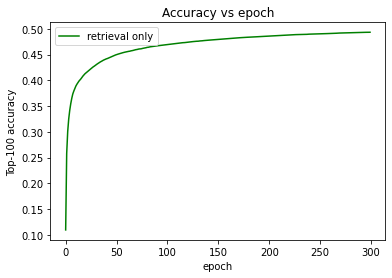

In [ ]:
num_validation_runs = len(retrieval_history.history["factorized_top_k/top_100_categorical_accuracy"])
epochs = [x for x in range(num_validation_runs)]

plt.plot(epochs, retrieval_history.history["factorized_top_k/top_100_categorical_accuracy"], label="retrieval only",c='g')
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("Top-100 accuracy");
plt.legend()

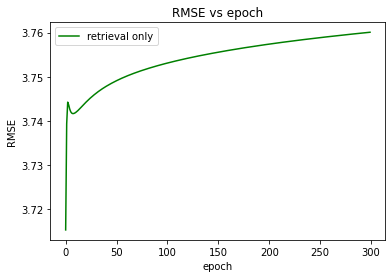

In [ ]:
num_validation_runs = len(retrieval_history.history["root_mean_squared_error"])
epochs = [x for x in range(num_validation_runs)]

plt.plot(epochs, retrieval_history.history["root_mean_squared_error"], label="retrieval only",c='g')
plt.title("RMSE vs epoch")
plt.xlabel("epoch")
plt.ylabel("RMSE");
plt.legend()


#### 2.Ranking Stage Only

In [ ]:
ranking_model = MovielensModel(rating_weight=1.0, retrieval_weight=0.0)
ranking_model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

num_epochs = 300
ranking_history = ranking_model.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=5,
    epochs=num_epochs,
    verbose=1)

Epoch 1/300
10/10 [==============================] - 10s 940ms/step - root_mean_squared_error: 2.0702 - factorized_top_k/top_1_categorical_accuracy: 3.0000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0025 - factorized_top_k/top_10_categorical_accuracy: 0.0051 - factorized_top_k/top_50_categorical_accuracy: 0.0293 - factorized_top_k/top_100_categorical_accuracy: 0.0587 - loss: 3.9712 - regularization_loss: 0.0000e+00 - total_loss: 3.9712
Epoch 2/300
10/10 [==============================] - 9s 945ms/step - root_mean_squared_error: 1.1851 - factorized_top_k/top_1_categorical_accuracy: 3.1250e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0026 - factorized_top_k/top_10_categorical_accuracy: 0.0053 - factorized_top_k/top_50_categorical_accuracy: 0.0295 - factorized_top_k/top_100_categorical_accuracy: 0.0590 - loss: 1.3937 - regularization_loss: 0.0000e+00 - total_loss: 1.3937
Epoch 3/300
10/10 [==============================] - 10s 946ms/step - root_mean_squared_error: 1.1213

In [ ]:
accuracy = ranking_history.history["factorized_top_k/top_100_categorical_accuracy"][-1]
rmse = ranking_history.history["root_mean_squared_error"][-1]

print(f"Retrieval top-100 accuracy: {accuracy:.3f}.")
print(f"Ranking RMSE: {rmse:.3f}.")

Retrieval top-100 accuracy: 0.074.
Ranking RMSE: 0.874.


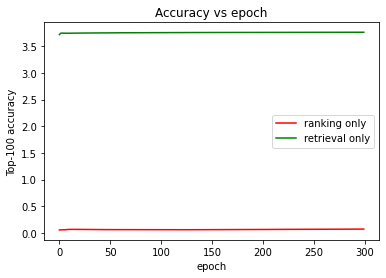

In [ ]:
num_validation_runs = len(ranking_history.history["factorized_top_k/top_100_categorical_accuracy"])
epochs = [x for x in range(num_validation_runs)]

plt.plot(epochs, ranking_history.history["factorized_top_k/top_100_categorical_accuracy"], label="ranking only",c='r')
plt.plot(epochs, retrieval_history.history["root_mean_squared_error"], label="retrieval only",c='g')
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("Top-100 accuracy");
plt.legend()

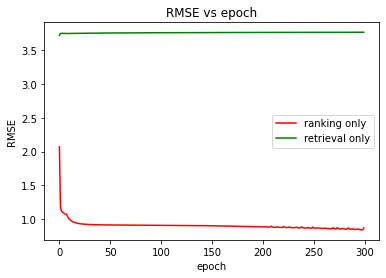

In [ ]:
num_validation_runs = len(ranking_history.history["root_mean_squared_error"])
epochs = [x for x in range(num_validation_runs)]
plt.plot(epochs, ranking_history.history["root_mean_squared_error"], label="ranking only",c='r')
plt.plot(epochs, retrieval_history.history["root_mean_squared_error"], label="retrieval only",c='g')
plt.title("RMSE vs epoch")
plt.xlabel("epoch")
plt.ylabel("RMSE")
plt.legend()

#### 3.Two Stage Recommender with both Retrieval and Ranking Stage

In [ ]:
joint_model = MovielensModel(rating_weight=1.0, retrieval_weight=1.0)
joint_model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

num_epochs = 300
joint_history = joint_model.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=5,
    epochs=num_epochs,
    verbose=1)

Epoch 1/300
10/10 [==============================] - 10s 920ms/step - root_mean_squared_error: 2.5272 - factorized_top_k/top_1_categorical_accuracy: 1.0000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0012 - factorized_top_k/top_10_categorical_accuracy: 0.0037 - factorized_top_k/top_50_categorical_accuracy: 0.0473 - factorized_top_k/top_100_categorical_accuracy: 0.1140 - loss: 69803.4624 - regularization_loss: 0.0000e+00 - total_loss: 69803.4624
Epoch 2/300
10/10 [==============================] - 10s 948ms/step - root_mean_squared_error: 1.2143 - factorized_top_k/top_1_categorical_accuracy: 0.0011 - factorized_top_k/top_5_categorical_accuracy: 0.0125 - factorized_top_k/top_10_categorical_accuracy: 0.0279 - factorized_top_k/top_50_categorical_accuracy: 0.1437 - factorized_top_k/top_100_categorical_accuracy: 0.2656 - loss: 67475.5185 - regularization_loss: 0.0000e+00 - total_loss: 67475.5185
Epoch 3/300
10/10 [==============================] - 9s 926ms/step - root_mean_squared_e

In [ ]:
accuracy = joint_history.history["factorized_top_k/top_100_categorical_accuracy"][-1]
rmse = joint_history.history["root_mean_squared_error"][-1]

print(f"Retrieval top-100 accuracy: {accuracy:.3f}.")
print(f"Ranking RMSE: {rmse:.3f}.")

Retrieval top-100 accuracy: 0.492.
Ranking RMSE: 0.877.


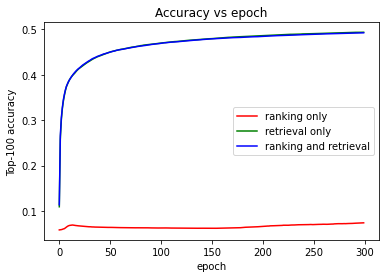

In [ ]:
num_validation_runs = len(retrieval_history.history["factorized_top_k/top_100_categorical_accuracy"])
epochs = [x for x in range(num_validation_runs)]

plt.plot(epochs, ranking_history.history["factorized_top_k/top_100_categorical_accuracy"], label="ranking only",c='r')
plt.plot(epochs, retrieval_history.history["factorized_top_k/top_100_categorical_accuracy"], label="retrieval only",c='g')
plt.plot(epochs, joint_history.history["factorized_top_k/top_100_categorical_accuracy"], label="ranking and retrieval",c='b')
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("Top-100 accuracy");
plt.legend()

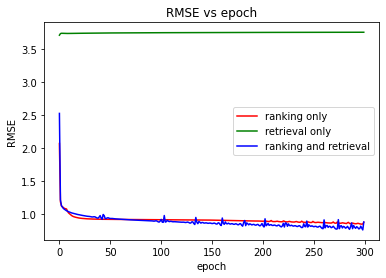

In [ ]:
num_validation_runs = len(retrieval_history.history["root_mean_squared_error"])
epochs = [x for x in range(num_validation_runs)]

plt.plot(epochs, ranking_history.history["root_mean_squared_error"], label="ranking only",c='r')
plt.plot(epochs, retrieval_history.history["root_mean_squared_error"], label="retrieval only",c='g')
plt.plot(epochs, joint_history.history["root_mean_squared_error"], label="ranking and retrieval",c='b')
plt.title("RMSE vs epoch")
plt.xlabel("epoch")
plt.ylabel("RMSE");
plt.legend()
